<a href="https://colab.research.google.com/github/atharvakale31/PR_ML/blob/master/Modeling_with_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

## Hierarchical Linear Regression

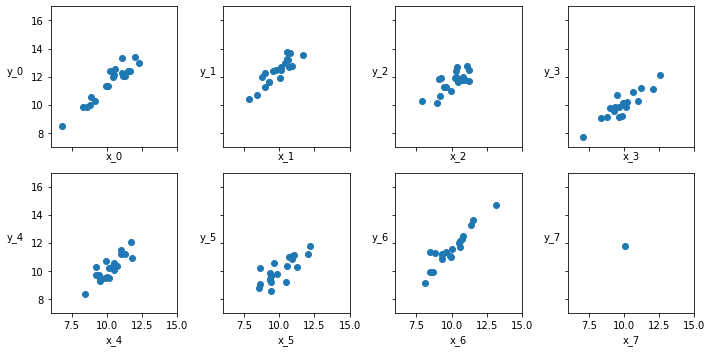

In [2]:
N = 20 
M = 8
idx = np.repeat(range(M-1), N) 
idx = np.append(idx, 7) 
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M) 
beta_real = np.random.beta(6, 1, size=M) 
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx)) 
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True) 
ax = np.ravel(ax) 
j, k = 0, N
for i in range(M):
  ax[i].scatter(x_m[j:k], y_m[j:k]) 
  ax[i].set_xlabel(f'x_{i}')
  ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15) 
  ax[i].set_xlim(6, 15) 
  ax[i].set_ylim(7, 17)
  j += N 
  k += N
plt.tight_layout()

In [3]:
x_centered = x_m - x_m.mean()

In [4]:
with pm.Model() as unpooled_model: 
  α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M) 
  β = pm.Normal('β', mu=0, sd=10, shape=M) 
  ϵ = pm.HalfCauchy('ϵ', 5) 
  ν = pm.Exponential('ν', 1/30)
  y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)
  α = pm.Deterministic('α', α_tmp - β * x_m.mean())
  trace_up = pm.sample(2000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, ϵ, β, α_tmp]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd160984210>],
      dtype=object)

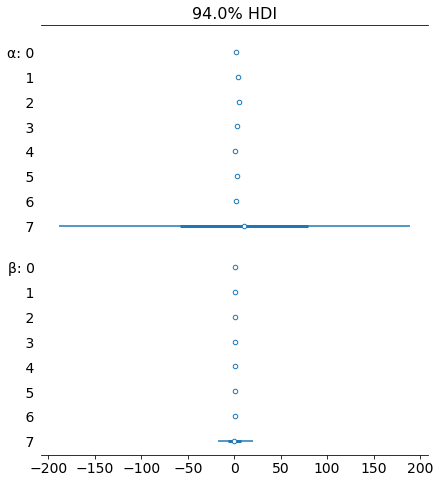

In [5]:
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)

In [6]:
with pm.Model() as hierarchical_model: # hyper-priors 
  α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10) 
  α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10) 
  β_μ = pm.Normal('β_μ', mu=0, sd=10) 
  β_σ = pm.HalfNormal('β_σ', sd=10)
  # priors 
  α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M) 
  β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M) 
  ϵ = pm.HalfCauchy('ϵ', 5) 
  ν = pm.Exponential('ν', 1/30)
  y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)
  α = pm.Deterministic('α', α_tmp - β * x_m.mean()) 
  α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean()) 
  α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
  trace_hm = pm.sample(1000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd156df14d0>],
      dtype=object)

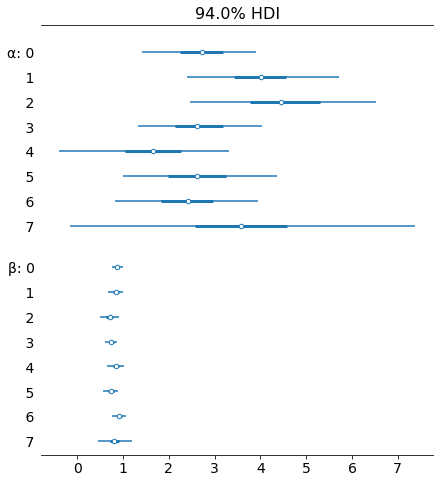

In [7]:
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)

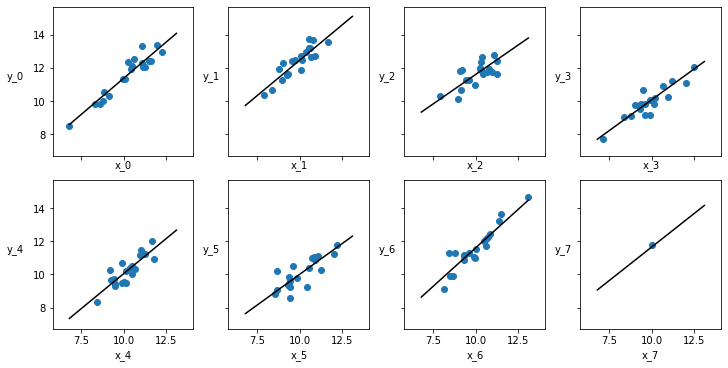

In [8]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax) 
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10) 
for i in range(M):
  ax[i].scatter(x_m[j:k], y_m[j:k]) 
  ax[i].set_xlabel(f'x_{i}')
  ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0) 
  alpha_m = trace_hm['α'][:, i].mean() 
  beta_m = trace_hm['β'][:, i].mean()
  ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
  plt.xlim(x_m.min()-1, x_m.max()+1) 
  plt.ylim(y_m.min()-1, y_m.max()+1) 
  j += N 
  k += N

# Polynomial Regression

In [9]:
x_2 = ans[ans.group == 'II']['x'].values 
y_2 = ans[ans.group == 'II']['y'].values 
x_2 = x_2 - x_2.mean()
plt.scatter(x_2, y_2) 
plt.xlabel('x')
plt.ylabel('y', rotation=0)

NameError: ignored

In [ ]:
with pm.Model() as model_poly:
  α = pm.Normal('α', mu=y_2.mean(), sd=1) 
  β1 = pm.Normal('β1', mu=0, sd=1) 
  β2 = pm.Normal('β2', mu=0, sd=1) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  mu = α + β1 * x_2 + β2 * x_2**2 
  y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2) 
  trace_poly = pm.sample(2000)

In [ ]:
x_p = np.linspace(-6, 6) 
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() *x_p + trace_poly['β2'].mean() * x_p**2 
plt.scatter(x_2, y_2) plt.xlabel('x')
plt.ylabel('y', rotation=0) 
plt.plot(x_p, y_p, c='C1')

# Multiple Linear Regression

In [12]:
np.random.seed(314) 
N = 100
alpha_real = 2.5 
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True) 
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [17]:
def scatter_plot(x, y):
  plt.figure(figsize=(10, 10)) 
  for idx, x_i in enumerate(x.T): 
    plt.subplot(2, 2, idx+1) 
    plt.scatter(x_i, y) 
    plt.xlabel(f'x_{idx+1}') 
    plt.ylabel(f'y', rotation=0)
  plt.subplot(2, 2, idx+2) 
  plt.scatter(x[:, 0], x[:, 1]) 
  plt.xlabel(f'x_{idx}')
  plt.ylabel(f'x_{idx+1}', rotation=0)

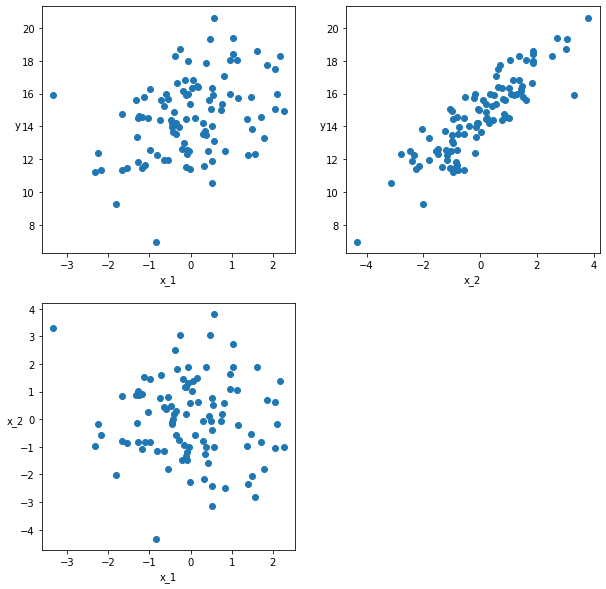

In [18]:
scatter_plot(X_centered, y)

In [19]:
with pm.Model() as model_mlr: 
  α_tmp = pm.Normal('α_tmp', mu=0, sd=10) 
  β = pm.Normal('β', mu=0, sd=1, shape=2) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α_tmp + pm.math.dot(X_centered, β) 
  α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β)) 
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_mlr = pm.sample(2000)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α_tmp]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


In [20]:
varnames = ['α', 'β', 'ϵ']
az.summary(trace_mlr, var_names=varnames)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.851,0.443,1.034,2.693,0.005,0.004,6513.0,3120.0,1.0
β[0],0.969,0.043,0.891,1.053,0.001,0.000,6535.0,3115.0,1.0
β[1],1.470,0.032,1.414,1.533,0.000,0.000,6488.0,3270.0,1.0
ϵ,0.474,0.036,0.406,0.541,0.000,0.000,5361.0,2351.0,1.0


In [21]:
np.random.seed(42) 
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1) #x_2 = x_1 + np.random.normal(size=N, scale=0.01) 
y = x_1 + np.random.normal(size=N) 
X = np.vstack((x_1, x_2)).T

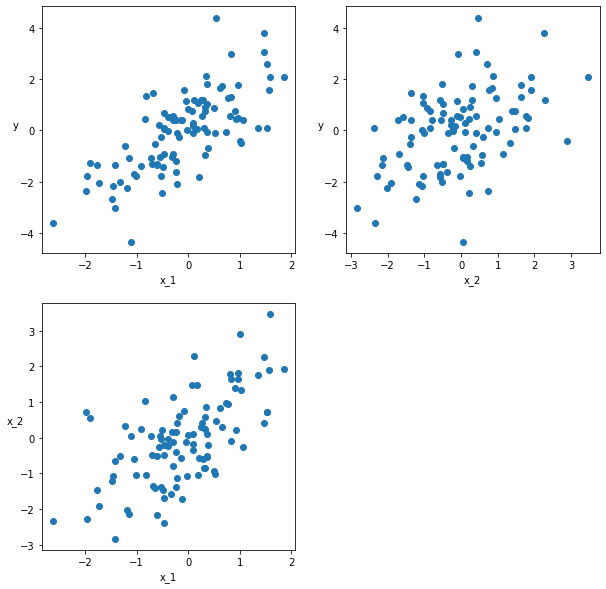

In [22]:
scatter_plot(X, y)

In [23]:
with pm.Model() as m_x1x2: 
  α = pm.Normal('α', mu=0, sd=10) 
  β1 = pm.Normal('β1', mu=0, sd=10) 
  β2 = pm.Normal('β2', mu=0, sd=10) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + β1 * X[:, 0] + β2 * X[:, 1] 
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_x1x2 = pm.sample(2000)
with pm.Model() as m_x1: 
  α = pm.Normal('α', mu=0, sd=10)
  β1 = pm.Normal('β1', mu=0, sd=10) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + β1 * X[:, 0]
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_x1 = pm.sample(2000)
with pm.Model() as m_x2: 
  α = pm.Normal('α', mu=0, sd=10) 
  β2 = pm.Normal('β2', mu=0, sd=10) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + β2 * X[:, 1]
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_x2 = pm.sample(2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β2, β1, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β1, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β2, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd15b544710>],
      dtype=object)

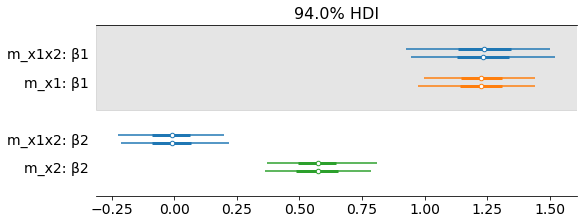

In [24]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2], model_names=['m_x1x2', 'm_x1', 'm_x2'], var_names=['β1', 'β2'],
combined=False, colors='cycle', figsize=(8, 3))

In [26]:
np.random.seed(42) 
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01) 
y = x_1 + np.random.normal(size=N) 
X = np.vstack((x_1, x_2)).T

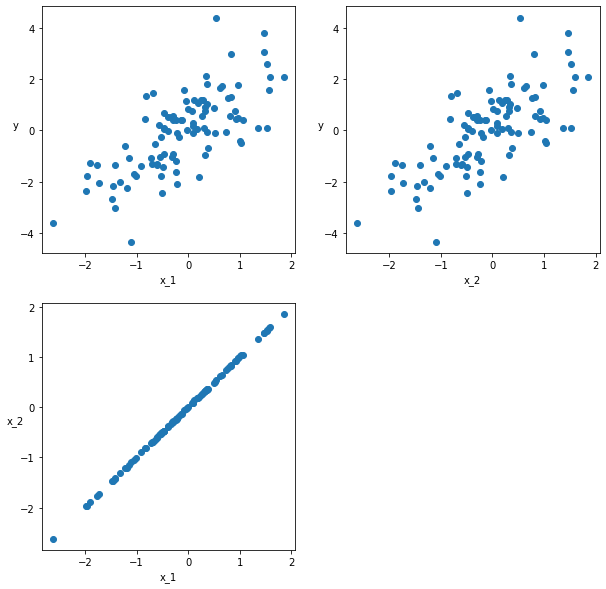

In [27]:
scatter_plot(X, y)

In [28]:
with pm.Model() as model_red: 
  α = pm.Normal('α', mu=0, sd=10) 
  β = pm.Normal('β', mu=0, sd=10, shape=2) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + pm.math.dot(X, β) 
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_red = pm.sample(2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 113 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd15a4bc4d0>],
      dtype=object)

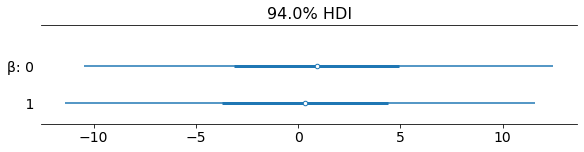

In [29]:
az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8, 2))

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


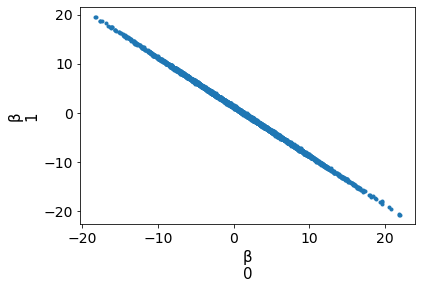

In [30]:
az.plot_pair(trace_red, var_names=['β'])

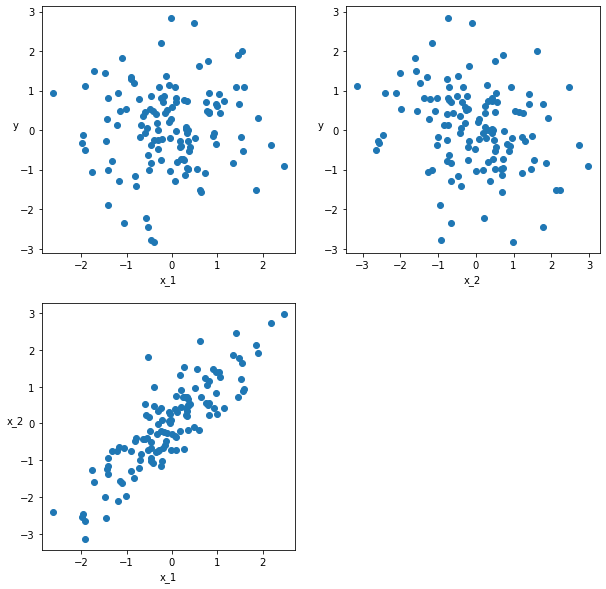

In [32]:
np.random.seed(42) 
N = 126 
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5) 
y = np.random.normal(x_1 - x_2) 
X = np.vstack((x_1, x_2)).T 
scatter_plot(X, y)

In [34]:
with pm.Model() as m_x1x2: 
  α = pm.Normal('α', mu=0, sd=10) 
  β1 = pm.Normal('β1', mu=0, sd=10) 
  β2 = pm.Normal('β2', mu=0, sd=10) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + β1 * X[:, 0] + β2 * X[:, 1] 
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_x1x2 = pm.sample(2000)
with pm.Model() as m_x1: 
  α = pm.Normal('α', mu=0, sd=10)
  β1 = pm.Normal('β1', mu=0, sd=10) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + β1 * X[:, 0]
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_x1 = pm.sample(2000)
with pm.Model() as m_x2: 
  α = pm.Normal('α', mu=0, sd=10) 
  β2 = pm.Normal('β2', mu=0, sd=10) 
  ϵ = pm.HalfCauchy('ϵ', 5)
  μ = α + β2 * X[:, 1]
  y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y) 
  trace_x2 = pm.sample(2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β2, β1, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  from ipykernel import kernelapp as app
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β1, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β2, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd14cb8f750>],
      dtype=object)

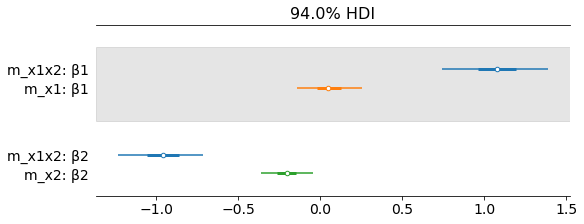

In [35]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2], model_names=['m_x1x2', 'm_x1', 'm_x2'], var_names=['β1', 'β2'],
combined=True, colors='cycle', figsize=(8, 3))